# Deep Recurrent Q-Network

Implement a Deep Recurrent Q-Network, which can solve Partially Observable Markov Decision Processes.

To learn more about DRQNs, see my blog post on them here: https://medium.com/p/68463e9aeefc.

In [1]:
import csv
from gridworld import GameEnvironment
import gym
from helper import process_state, save_to_monitor, update_target, update_target_graph
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import scipy.misc
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tqdm import trange
%matplotlib inline

### Load the Game Environment

Feel free to adjust the size of the gridworld. Making it smaller (adjusting size) provides an easier task for our DRQN agent, while making the world larger increases the challenge.

Initializing the Gridworld with True limits the field of view, resulting in a partially observable MDP. Initializing it with False provides the agent with the entire environment, resulting in a fully observable MDP.

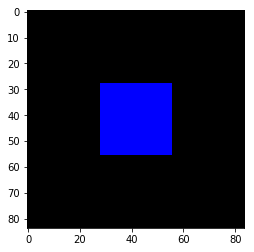

In [2]:
env = GameEnvironment(partial=True, size=9)

Above is an example of a starting environment in our simple game. The agent controls the blue square, and can move up, down, left, or right. The goal is to move to the green square (for +1 reward) and avoid the red square (for -1 reward). When the agent moves through a green or red square, it is randomly moved to a new place in the environment.

### Implementing the network

In [1]:
class QNetwork(object):
    
    def __init__(self, n_hidden, rnn_cell, scope):
        # The network receives a frame from the game, flattened into an array.
        # It then resizes and processes it through four convolutional layers.
        self.scalar_input = tf.placeholder(shape=[None, 21168], dtype=tf.float32)
        self.image_in = tf.reshape(self.scalar_input, shape=[-1, 84, 84, 3])
        self.conv1 = slim.conv2d(inputs=self.image_in, num_outputs=32,
                                 kernel_size=[8, 8], stride=[4, 4], padding='VALID', 
                                 biases_initializer=None, scope=scope + '_conv1')
        self.conv2 = slim.conv2d(inputs=self.conv1, num_outputs=64,
                                 kernel_size=[4, 4], stride=[2, 2], padding='VALID', 
                                 biases_initializer=None, scope=scope + '_conv2')
        self.conv3 = slim.conv2d(inputs=self.conv2, num_outputs=64,
                                 kernel_size=[3, 3], stride=[1, 1], padding='VALID', 
                                 biases_initializer=None, scope=scope + '_conv3')
        self.conv4 = slim.conv2d(inputs=self.conv3, num_outputs=n_hidden,
                                 kernel_size=[7, 7], stride=[1, 1], padding='VALID', 
                                 biases_initializer=None, scope=scope + '_conv4')
        
        self.sequence_length = tf.placeholder(dtype=tf.int32)
        
        # Take the output from the final convolutional layer and send it 
        # to a recurrent layer. The input must be reshaped into 
        # [batch, trace, units] for RNN processing, and then returned to
        # [batch, units] when sent through the upper levels.
        self.batch_size = tf.placeholder(dtype=tf.int32, shape=[])
        self.conv_flat = tf.reshape(slim.flatten(self.conv4), [self.batch_size, self.sequence_length, n_hidden])
        self.state_in = rnn_cell.zero_state(self.batch_size, tf.float32)
        self.rnn, self.rnn_state = tf.nn.dynamic_rnn(inputs=self.conv_flat, cell=rnn_cell, dtype=tf.float32, 
                                                     initial_state=self.state_in, scope=scope + '_rnn')
        self.rnn = tf.reshape(self.rnn, shape=[-1, n_hidden])
        
        # The output from the recurrent layer is then split into separate 
        # Advantage and Value streams.
        self.stream_a, self.stream_v = tf.split(self.rnn, 2, 1)
        self.aw = tf.Variable(tf.random_normal([n_hidden // 2, 4]))
        self.vw = tf.Variable(tf.random_normal([n_hidden // 2, 1]))
        self.advantage = tf.matmul(self.stream_a, self.aw)
        self.value = tf.matmul(self.stream_v, self.vw)
        self.salience = tf.gradients(self.advantage, self.image_in)
        
        # then combine them together to get our final Q-values
        self.q_out = self.value + tf.subtract(self.advantage, tf.reduce_mean(self.advantage, axis=1, keepdims=True))
        self.predict = tf.argmax(self.q_out, 1)
        
        # obtain the loss by taking the sum of squares difference between 
        # the target and predicted Q-values
        self.target_q = tf.placeholder(shape=[None], dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, 4, dtype=tf.float32)
        
        self.q = tf.reduce_sum(tf.multiply(self.q_out, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.target_q - self.q)
        
        # In order to only propagate accurate gradients through the network,
        # we will mask the first half of the losses for each trace as per
        # Lample & Chatlot 2016
        self.mask_a = tf.zeros([self.batch_size, self.sequence_length // 2])
        self.mask_b = tf.ones([self.batch_size, self.sequence_length // 2])
        self.mask = tf.concat([self.mask_a, self.mask_b], 1)
        self.mask = tf.reshape(self.mask, [-1])
        self.loss = tf.reduce_mean(self.td_error * self.mask)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.update_op = self.optimizer.minimize(self.loss)

### Experience Replay

This class lets us store experiences, then sample them randomly to train the network. Episode buffer stores experiences for each individal episode. Experience buffer stores entire episodes of experience, and sample() allows us to get training batches needed from the network.

In [4]:
class ExperienceBuffer(object):
    
    def __init__(self, buffer_size=1000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        n = len(self.buffer) + 1
        if n >= self.buffer_size:
            self.buffer[0:n-self.buffer_size] = []
            
        self.buffer.append(experience)
        
    def sample(self, batch_size, trace_length):
        sampled_episodes = random.sample(self.buffer, batch_size)
        sampled_traces = []
        for episode in sampled_episodes:
            point = np.random.randint(0, len(episode) + 1 - trace_length)
            sampled_traces.append(episode[point:point+trace_length])
            
        return np.reshape(np.array(sampled_traces), [batch_size * trace_length, 5])

### Train the network

In [5]:
# hyperparams:

batch_size = 4  # number experience traces to use for each training step
trace_length = 8  # length of each experience trace when training
update_freq = 5  # frequency of performing a training step
gamma = 0.99  # discount factor on the target Q-values
start_epsilon = 1  # starting chance of random action
end_epsilon = 0.1  # final chance of random action
annealing_steps = 10000  # number steps of training to reduce start_epsilon to end_epsilon
#n_episodes = 10000  # number episodes of game environment to train network
n_episodes = 500
n_pretrain_steps = 10000  # number steps of random actions before training begins
max_episode_length = 50  # max allowed length of our episode
n_hidden = 512  # size of final convolutional layer before splitting it into Advantage and Value streams
time_per_step = 1  # length of each step used in gif creation
summary_length = 100  # number episodes to periodically save for analysis
tau = 0.001
load_model = False  # whether to load a saved model
save_path = 'drqn'  # path to save our model to

Learning should occur in a couple hours on a moderately powerful machine (GTX970). (Getting Atari games to work will take at least a day of training on a powerful machine.)

In [15]:
def train():
    tf.reset_default_graph()
    
    # we define the cells for the primary and target Q-networks
    cell_main = tf.contrib.rnn.BasicLSTMCell(num_units=n_hidden, state_is_tuple=True)
    cell_target = tf.contrib.rnn.BasicLSTMCell(num_units=n_hidden, state_is_tuple=True)
    main_network = QNetwork(n_hidden, cell_main, 'main')
    target_network = QNetwork(n_hidden, cell_target, 'target')
    saver = tf.train.Saver()
    trainables = tf.trainable_variables()
    target_ops = update_target_graph(trainables, tau)
    buffer = ExperienceBuffer()
    epsilon = start_epsilon
    step_drop = (start_epsilon - end_epsilon) / annealing_steps
    js, rewards = [], []
    n_steps = 0
    
    # make path to save model, unless path already exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    # write the first line of the master log-file for the Control Center
    with open('monitor/log.csv', 'w') as f:
        writer = csv.writer(f, quoting=csv.QUOTE_ALL)
        writer.writerow(['Episode', 'Length', 'Reward', 'IMG', 'LOG', 'SAL'])
        
    with tf.Session() as sess:
        if load_model:
            print('Loading model...')
            ckpt = tf.train.get_checkpoint_state(save_path)
            saver.restore(sess, ckpt.model_checkpoint_path)
            
        sess.run(tf.global_variables_initializer())
        for i in range(n_episodes):
            episode_buffer = []
            
            # reset environment and get first new observation
            s_p = env.reset()
            s = process_state(s_p)
            done = False
            total_reward = 0
            j = 0
            
            # reset the recurrent layer's hidden state
            state = (np.zeros([1, n_hidden]), np.zeros([1, n_hidden]))
            
            # Train the Q-network
            # if the agent takes longer to reach either of the blocks, then end the trial
            while j < max_episode_length:
                j += 1
                
                # choose an action greedily from the Q-network, 
                # with epsilon chance of random action
                if np.random.rand(1) < epsilon or n_steps < n_pretrain_steps:
                    state1 = sess.run(main_network.rnn_state, feed_dict={
                        main_network.scalar_input: [s / 255.],
                        main_network.sequence_length: 1,
                        main_network.state_in: state,
                        main_network.batch_size: 1
                    })
                    a = np.random.randint(0, 4)
                else:
                    a, state1 = sess.run([main_network.predict, main_network.rnn_state], feed_dict={
                        main_network.scalar_input: [s / 255.],
                        main_network.sequence_length: 1,
                        main_network.state_in: state,
                        main_network.batch_size: 1
                    })
                    a = a[0]
                
                s1_p, reward, done = env.step(a)
                s1 = process_state(s1_p)
                n_steps += 1
                
                # save the experience to our episode buffer
                episode_buffer.append(np.reshape(np.array([s, a, reward, s1, done]), [1, 5]))
                
                if n_steps > n_pretrain_steps:
                    if epsilon > end_epsilon:
                        epsilon -= step_drop
                        
                    if n_steps % update_freq == 0:
                        update_target(target_ops, sess)
                        state_train = (np.zeros([batch_size, n_hidden]), np.zeros([batch_size, n_hidden]))
                        
                        # get a random batch of experiences
                        train_batch = buffer.sample(batch_size, trace_length)
                        
                        # perform the Double-DQN update to the target Q-values
                        q1 = sess.run(main_network.predict, feed_dict={
                            main_network.scalar_input: np.vstack(train_batch[:, 3] / 255.),
                            main_network.sequence_length: trace_length,
                            main_network.state_in: state_train,
                            main_network.batch_size: batch_size
                        })
                        q2 = sess.run(target_network.q_out, feed_dict={
                            target_network.scalar_input: np.vstack(train_batch[:, 3] / 255.),
                            target_network.sequence_length: trace_length,
                            target_network.state_in: state_train,
                            target_network.batch_size: batch_size
                        })
                        end_multiplier = -train_batch[:, 4] - 1
                        double_q = q2[range(batch_size * trace_length), q1]
                        target_q = train_batch[:, 2] + gamma * double_q * end_multiplier
                        
                        # update the network with our target values
                        _ = sess.run(main_network.update_op, feed_dict={
                            main_network.scalar_input: np.vstack(train_batch[:, 0] / 255.),
                            main_network.target_q: target_q,
                            main_network.actions: train_batch[:, 1],
                            main_network.sequence_length: trace_length,
                            main_network.state_in: state_train,
                            main_network.batch_size: batch_size
                        })
                        
                total_reward += reward
                s = s1
                s_p = s1_p
                state = state1
                
                if done:
                    break
                    
            buffer_array = np.array(episode_buffer)
            episode_buffer = list(zip(buffer_array))
            buffer.add(episode_buffer)
            js.append(j)
            rewards.append(total_reward)
            
            # periodically save the model
            if i % 1000 == 0:
                saver.save(sess, '{}/model-{}'.format(save_path, i))
                print('Saved model')
                
            if len(rewards) % 100 == 0 and i != 0:
                print('Number steps:', n_steps, 'mean reward:', np.mean(rewards[-10:]), 'epsilon:', epsilon)

                # record performance metrics and episode logs for the Control Center
                save_to_monitor(i, rewards, js, np.reshape(np.array(episode_buffer), [len(episode_buffer), 5]), 
                                summary_length, n_hidden, sess, main_network, time_per_step)
                
        saver.save(sess, '{}/model-{}'.format(save_path, i))
        
    print('Successful episodes %:', str(sum(rewards) / n_episodes))
    
    return rewards, js

In [10]:
rewards, _ = train()

Saved model
Number steps: 5000 mean reward: 0.5 epsilon: 1


 98%|█████████▊| 51/52 [00:00<00:00, 1410.71it/s]


Number steps: 10000 mean reward: 0.5 epsilon: 1


 98%|█████████▊| 51/52 [00:00<00:00, 1516.42it/s]


Number steps: 15000 mean reward: 2.2 epsilon: 0.5499999999998275


 98%|█████████▊| 51/52 [00:00<00:00, 1095.93it/s]


Number steps: 20000 mean reward: 1.1 epsilon: 0.09999999999985551


 98%|█████████▊| 51/52 [00:00<00:00, 1090.51it/s]


Number steps: 25000 mean reward: 0.6 epsilon: 0.09999999999985551


 98%|█████████▊| 51/52 [00:00<00:00, 1588.82it/s]


Successful episodes %: 0.804


### Check Network Learning

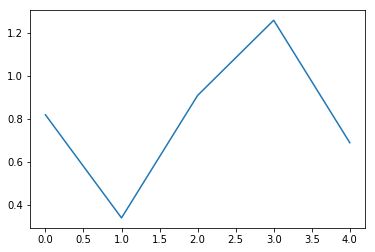

In [11]:
# mean reward over time
reward_mat = np.resize(np.array(rewards), [len(rewards) // 100, 100])
mean_reward = np.average(reward_mat, 1)
plt.plot(mean_reward)

### Test the network

In [12]:
# hyperparams:

epsilon = 0.1  # chance of random action
#n_episodes = 10000  # number episodes of game environment to train network
n_episodes = 500
max_episode_length = 50  # max allowed length of our episode
n_hidden = 512  # size of final convolutional layer before splitting it into Advantage and Value streams
time_per_step = 1  # length of each step used in gif creation
summary_length = 100  # number episodes to periodically save for analysis
load_model = True  # whether to load a saved model
save_path = 'drqn'  # path to save our model to

In [16]:
def test():
    tf.reset_default_graph()
    
    # we define the cells for the primary and target Q-networks
    cell_main = tf.contrib.rnn.BasicLSTMCell(num_units=n_hidden, state_is_tuple=True)
    cell_target = tf.contrib.rnn.BasicLSTMCell(num_units=n_hidden, state_is_tuple=True)
    main_network = QNetwork(n_hidden, cell_main, 'main')
    target_network = QNetwork(n_hidden, cell_target, 'target')
    saver = tf.train.Saver(max_to_keep=2)
    js, rewards = [], []
    n_steps = 0
    
    # make path to save model, unless path already exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    # write the first line of the master log-file for the Control Center
    with open('monitor/log.csv', 'w') as f:
        writer = csv.writer(f, quoting=csv.QUOTE_ALL)
        writer.writerow(['Episode', 'Length', 'Reward', 'IMG', 'LOG', 'SAL'])
        
    with tf.Session() as sess:
        if load_model:
            print('Loading model...')
            ckpt = tf.train.get_checkpoint_state(save_path)
            saver.restore(sess, ckpt.model_checkpoint_path)
        else:
            sess.run(tf.global_variables_initializer())

        for i in range(n_episodes):
            episode_buffer = []
            
            # reset environment and get first new observation
            s_p = env.reset()
            s = process_state(s_p)
            done = False
            total_reward = 0
            j = 0
            
            # reset the recurrent layer's hidden state
            state = (np.zeros([1, n_hidden]), np.zeros([1, n_hidden]))
            
            # Train the Q-network
            # if the agent takes longer to reach either of the blocks, then end the trial
            while j < max_episode_length:
                j += 1
                
                # choose an action greedily from the Q-network, 
                # with epsilon chance of random action
                if np.random.rand(1) < epsilon:
                    state1 = sess.run(main_network.rnn_state, feed_dict={
                        main_network.scalar_input: [s / 255.],
                        main_network.sequence_length: 1,
                        main_network.state_in: state,
                        main_network.batch_size: 1
                    })
                    a = np.random.randint(0, 4)
                else:
                    a, state1 = sess.run([main_network.predict, main_network.rnn_state], feed_dict={
                        main_network.scalar_input: [s / 255.],
                        main_network.sequence_length: 1,
                        main_network.state_in: state,
                        main_network.batch_size: 1
                    })
                    a = a[0]
                
                s1_p, reward, done = env.step(a)
                s1 = process_state(s1_p)
                n_steps += 1
                
                # save the experience to our episode buffer
                episode_buffer.append(np.reshape(np.array([s, a, reward, s1, done]), [1, 5]))
                
                total_reward += reward
                s = s1
                s_p = s1_p
                state = state1
                
                if done:
                    break
                    
            buffer_array = np.array(episode_buffer)
            js.append(j)
            rewards.append(total_reward)
            
            # periodically save the model
            if len(rewards) % summary_length == 0 and i != 0:
                print('Number steps:', n_steps, 'mean reward:', np.mean(rewards[-10:]), 'epsilon:', epsilon)

                # record performance metrics and episode logs for the Control Center
                save_to_monitor(i, rewards, js, np.reshape(np.array(episode_buffer), [len(episode_buffer), 5]), 
                                summary_length, n_hidden, sess, main_network, time_per_step)
                
    print('Successful episodes %:', str(sum(rewards) / n_episodes))
    
    return rewards, js

In [17]:
rewards, _ = test()

Loading model...
INFO:tensorflow:Restoring parameters from drqn/model-499
Number steps: 5000 mean reward: 0.6 epsilon: 0.1


 98%|█████████▊| 51/52 [00:00<00:00, 1244.20it/s]


Number steps: 10000 mean reward: 0.7 epsilon: 0.1


 98%|█████████▊| 51/52 [00:00<00:00, 1277.57it/s]


Number steps: 15000 mean reward: 0.5 epsilon: 0.1


 98%|█████████▊| 51/52 [00:00<00:00, 1227.65it/s]


Number steps: 20000 mean reward: 0.7 epsilon: 0.1


 98%|█████████▊| 51/52 [00:00<00:00, 1080.63it/s]


Number steps: 25000 mean reward: 0.4 epsilon: 0.1


 98%|█████████▊| 51/52 [00:00<00:00, 1360.25it/s]


Successful episodes %: 0.742
